In [174]:
import numpy as np
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from mpl_toolkits.basemap import Basemap
import os
import warnings

In [175]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

lon_g = np.load('will_lons.npy')[1:, 1:]
lat_g = np.load('will_lats.npy')[1:, 1:]


In [176]:
# y coordinates
minlat = -0.1
maxlat = 7950000.0/1000000

# x coordinates
minlon = -0.1
maxlon = 7950000.0/1000000


### Generate synthetic observations

In [177]:
A = "SyntheticSnow"
B = "SyntheticIce"

# Create the observations file
subprocess.run([
    "./mksynthetic", 
    "-m", str(A), # Model for snow
    "-m", str(B), # Model for ice
    "-i", "synthetic/observations.txt",    # input points from real data
    "-x", str(minlon), "-X", str(maxlon),  # same region bounds as before
    "-y", str(minlat), "-Y", str(maxlat),
    "-o", "synthetic/synthetic_obs.txt",     # Observations with noise
    "-O", "synthetic/synthetic_true.txt",    # Observations without noise, the 'actual' data
    "-n", str(0.05),                           # Standard deviation of independent Gaussian noise to be added to both snow and ice
    "-I", "synthetic/syntheticobs_true.img",  # translated image of the actual data
    "-W", str(160), "-H", str(160)            # width and height of the image
])

Model  0 : SyntheticSnow
Model  1 : SyntheticIce
10118 observations


CompletedProcess(args=['./mksynthetic', '-m', 'SyntheticSnow', '-m', 'SyntheticIce', '-i', 'synthetic/observations.txt', '-x', '-0.1', '-X', '7.95', '-y', '-0.1', '-Y', '7.95', '-o', 'synthetic/synthetic_obs.txt', '-O', 'synthetic/synthetic_true.txt', '-n', '0.05', '-I', 'synthetic/syntheticobs_true.img', '-W', '160', '-H', '160'], returncode=0)

In [178]:
# masking the image
def mask_image(observations, data):
    mask_data = np.copy(data)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                mask_data[i][j] = np.nan
    return mask_data

mask = np.loadtxt('synthetic/dailyFB_50km_2019-2020_season.pkl_ice_masked')
real_snow = np.loadtxt("synthetic/syntheticobs_true.img.A")
real_ice = np.loadtxt("synthetic/syntheticobs_true.img.B")
masked_snow_image = mask_image(mask, real_snow)
masked_ice_image = mask_image(mask, real_ice)

### Plotting the actual synthetic data

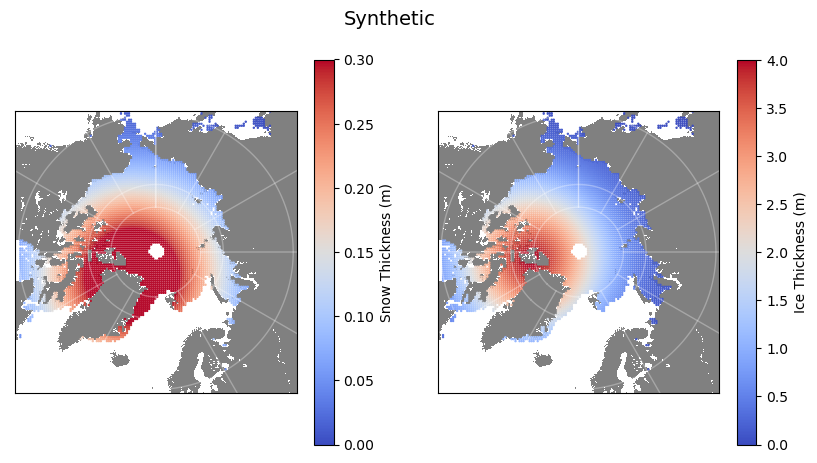

In [179]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)

fig.suptitle("Synthetic", fontsize=14)

m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=masked_snow_image, cmap="coolwarm", vmin=0, vmax=0.3)
plt.colorbar(label=r'Snow Thickness (m)')

ax = fig.add_subplot(122)
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=masked_ice_image, cmap="coolwarm", vmin=0, vmax=4)
plt.colorbar(label=r'Ice Thickness (m)')

plt.show()

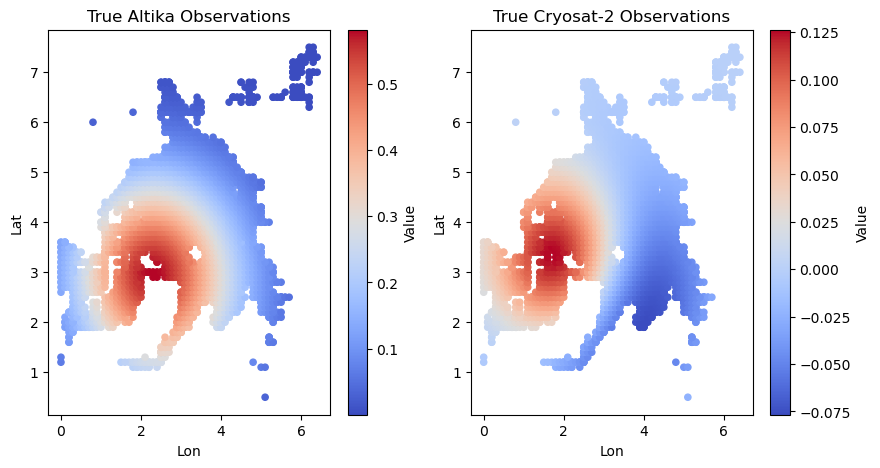

In [180]:
true = pd.read_table("synthetic/synthetic_true.txt", skiprows=1, names=['Lon','Lat','Type','Value','Sigma'], delimiter='\s+')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

true[true['Type']==1].plot(kind="scatter", x='Lon', y='Lat', c="Value", ax=ax[0], title='True Altika Observations', cmap='coolwarm')
true[true['Type']==0].plot(kind="scatter", x='Lon', y='Lat', c="Value", ax=ax[1], title='True Cryosat-2 Observations', cmap='coolwarm')

plt.show()

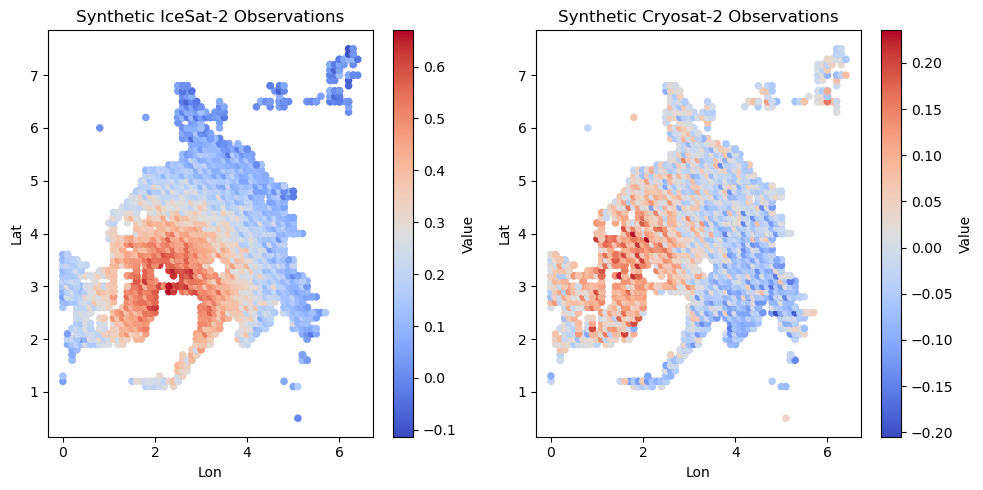

In [181]:
obs = pd.read_table("synthetic/synthetic_obs.txt", skiprows=1, names=["Lon", "Lat", "Type", "Value", "Sigma"], delimiter="\s+")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

obs[obs['Type']==1].plot(kind="scatter", x='Lon', y='Lat', c="Value", ax=ax[0], title='Synthetic IceSat-2 Observations', cmap='coolwarm')
obs[obs['Type']==0].plot(kind="scatter", x='Lon', y='Lat', c="Value", ax=ax[1], title='Synthetic Cryosat-2 Observations', cmap='coolwarm')

plt.tight_layout()
plt.show()

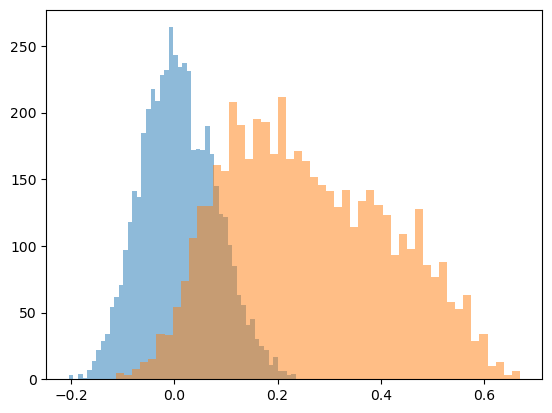

In [182]:
obs = pd.read_table("synthetic/synthetic_obs.txt", skiprows=1, delimiter="\s+")
plt.hist(np.asarray(obs)[:5060,3]. ravel(), alpha = 0.5, bins =50)
plt.hist(np.asarray(obs)[5060:,3]. ravel(), alpha = 0.5, bins=50)
plt.show()

### Inversion


In [183]:
parametrization = 0  # Tessalation parameter, 0 for Voronoi, 1 for Delauney, 2 for Delauney-Clougner
iterations_number = 250000
verbosity = 5000
independent_chains = 4
temperature_levels = 1
maximum_temperature = 5.0
iterations_between_tempering_attempts = 10

# Run inversion
subprocess.run([
    "mpirun", "-np", str(independent_chains * temperature_levels),
    "./snow_icept", 
    "-i", "synthetic/synthetic_obs.txt", 
    "-o", "results/", 
    "-P", "priors/synthetic/prior_snow.txt",
    "-P", "priors/synthetic/prior_ice.txt", 
    "-M", "priors/synthetic/positionprior_snow.txt", 
    "-M", "priors/synthetic/positionprior_ice.txt",
    "-H", "priors/synthetic/hierarchical_snow.txt", 
    "-H", "priors/synthetic/hierarchical_ice.txt", 
    "-x", str(minlon), "-X", str(maxlon),
    "-y", str(minlat), "-Y", str(maxlat),
    "-A", str(parametrization), "-A", str(parametrization),
    "-t", str(iterations_number), 
    "-v", str(verbosity),
    "-c", str(independent_chains),   # Independent chains to run at each temperature
    "-K", str(temperature_levels),   # Number of temperature levels for parallel tempering
    "-m", str(maximum_temperature),  # Maximum temperature for the parallel tempering log temperature
    "-e", str(iterations_between_tempering_attempts)    # Number of iterations between parallel tempering exchange attempts
    ])

CompletedProcess(args=['mpirun', '-np', '4', './snow_icept', '-i', 'synthetic/synthetic_obs.txt', '-o', 'results/', '-P', 'priors/synthetic/prior_snow.txt', '-P', 'priors/synthetic/prior_ice.txt', '-M', 'priors/synthetic/positionprior_snow.txt', '-M', 'priors/synthetic/positionprior_ice.txt', '-H', 'priors/synthetic/hierarchical_snow.txt', '-H', 'priors/synthetic/hierarchical_ice.txt', '-x', '-0.1', '-X', '7.95', '-y', '-0.1', '-Y', '7.95', '-A', '0', '-A', '0', '-t', '250000', '-v', '5000', '-c', '4', '-K', '1', '-m', '5.0', '-e', '10'], returncode=0)

In [184]:
# Step 3: Compute means 
parameter_W = 160
parameter_H = 160
skipping = 50000
thinning = 5

file_snow = f"images/snow"
file_ice = f"images/ice"


subprocess.run([
            "mpirun", "-np", str(independent_chains),
            "./post_mean_mpi", "-i", 
            "results/ch.dat", "-o", file_snow,
            "-x", str(minlon), "-X", str(maxlon),
            "-y", str(minlat), "-Y", str(maxlat),
            "-s", str(skipping),
            "-t", str(thinning),
            "-A", str(parametrization), "-A", str(parametrization),
            "-W", str(parameter_W), "-H", str(parameter_H),
            "-D", str(file_snow + "_stddev"),
            "-m", str(file_snow + "_median"),
            "-I", str(0)])

CompletedProcess(args=['mpirun', '-np', '4', './post_mean_mpi', '-i', 'results/ch.dat', '-o', 'images/snow', '-x', '-0.1', '-X', '7.95', '-y', '-0.1', '-Y', '7.95', '-s', '50000', '-t', '5', '-A', '0', '-A', '0', '-W', '160', '-H', '160', '-D', 'images/snow_stddev', '-m', 'images/snow_median', '-I', '0'], returncode=0)

In [185]:
subprocess.run([
            "mpirun", "-np", str(independent_chains),
            "./post_mean_mpi", "-i", 
            "results/ch.dat", "-o", file_ice,
            "-x", str(minlon), "-X", str(maxlon),
            "-y", str(minlat), "-Y", str(maxlat),
            "-s", str(skipping),
            "-t", str(thinning),
            "-A", str(parametrization), "-A", str(parametrization),
            "-W", str(parameter_W), "-H", str(parameter_H),
            "-D", str(file_ice + "_stddev"),
            "-m", str(file_ice + "_median"),
            "-I", str(1)])

CompletedProcess(args=['mpirun', '-np', '4', './post_mean_mpi', '-i', 'results/ch.dat', '-o', 'images/ice', '-x', '-0.1', '-X', '7.95', '-y', '-0.1', '-Y', '7.95', '-s', '50000', '-t', '5', '-A', '0', '-A', '0', '-W', '160', '-H', '160', '-D', 'images/ice_stddev', '-m', 'images/ice_median', '-I', '1'], returncode=0)

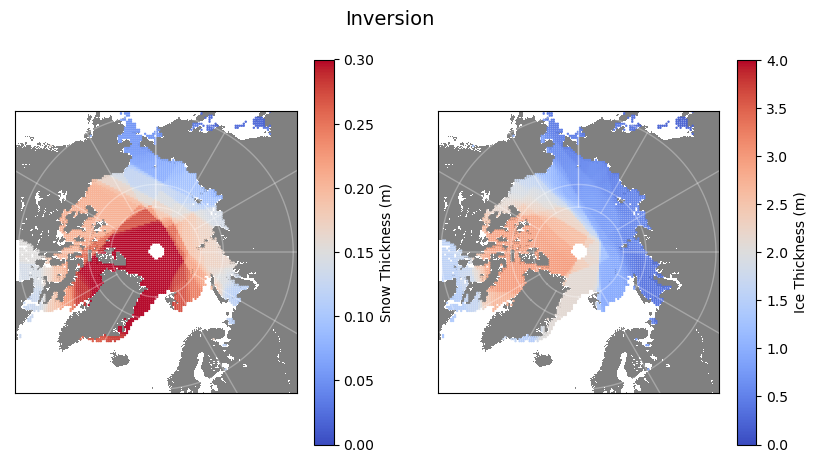

In [186]:
file_snow = f"images/snow"
file_ice = f"images/ice"
ice = np.loadtxt(file_ice)
snow = np.loadtxt(file_snow)
mask_snow = mask_image(mask, snow)
mask_ice = mask_image(mask, ice)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)

fig.suptitle("Inversion", fontsize=14)

m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=mask_snow, cmap="coolwarm", vmin=0, vmax=0.3)
plt.colorbar(label=r'Snow Thickness (m)')

ax = fig.add_subplot(122)
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=mask_ice, cmap="coolwarm", vmin=0, vmax=4)
plt.colorbar(label=r'Ice Thickness (m)')

plt.show()


         MD      RMSE        R2
0 -0.000183  0.029727  0.912802


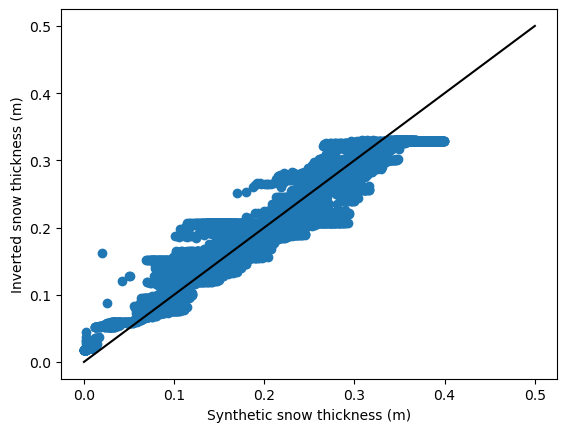

In [187]:
from sklearn.metrics import r2_score
results = []


# Flatten and remove NaN values from the arrays
masked_snow_image_flat = masked_snow_image.ravel()[~np.isnan(masked_snow_image.ravel())]
mask_snow_flat = mask_snow.ravel()[~np.isnan(mask_snow.ravel())]

error = mask_snow_flat - masked_snow_image_flat
md = np.mean(error)
rmse = np.sqrt( np.mean( (error)**2 ))

r2 = r2_score(masked_snow_image_flat, mask_snow_flat)
results.append([md, rmse, r2])
print (pd.DataFrame (results, columns = ['MD', 'RMSE', 'R2']) )

x = y = [0,0.5]
plt.scatter(masked_snow_image.ravel(),mask_snow.ravel())
plt.plot(x, y, 'k-')
plt.xlabel('Synthetic snow thickness (m)')
plt.ylabel('Inverted snow thickness (m)')
plt.show()

        MD      RMSE        R2
0 -0.00142  0.334073  0.907427


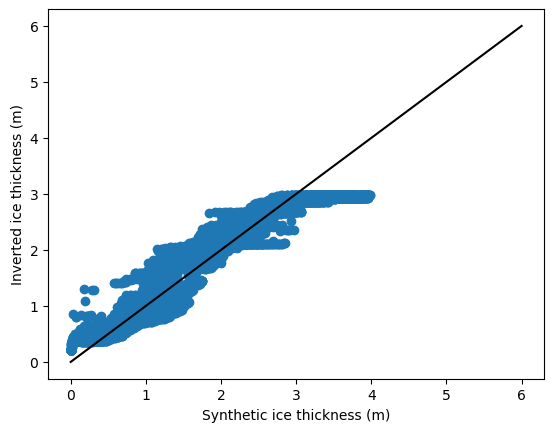

In [ ]:
results = []

# Flatten and remove NaN values from the arrays
masked_ice_image_flat = masked_ice_image.ravel()[~np.isnan(masked_ice_image.ravel())]
mask_ice_flat = mask_ice.ravel()[~np.isnan(mask_ice.ravel())]

error = mask_ice_flat - masked_ice_image_flat
md = np.mean(error)
rmse = np.sqrt( np.mean( (error)**2 ))

r2 = r2_score(masked_ice_image_flat, mask_ice_flat)
results.append([md, rmse, r2])
print (pd.DataFrame (results, columns = ['MD', 'RMSE', 'R2']) )

x = y = [0,4]
plt.scatter(masked_ice_image_flat,mask_ice_flat)
plt.plot(x, y, 'k-')
plt.xlabel('Synthetic ice thickness (m)')
plt.ylabel('Inverted ice thickness (m)')
plt.show()

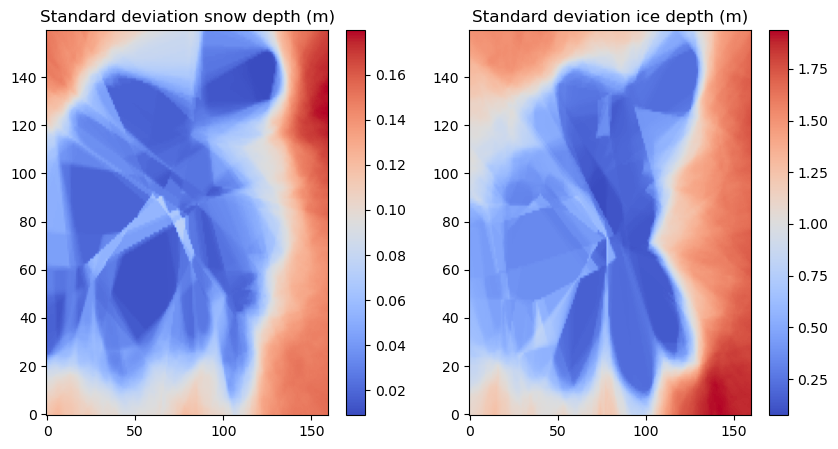

In [189]:
std_snow = f"images/snow_stddev"
std_ice = f"images/ice_stddev"
snow_median = np.loadtxt(std_snow)
ice_median = np.loadtxt(std_ice)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img = ax[0].imshow(snow_median,origin='lower', cmap = 'coolwarm',aspect= 'auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Standard deviation snow depth (m)')

img = ax[1].imshow(ice_median,origin='lower', cmap= 'coolwarm', aspect= 'auto')
plt.colorbar(img, ax=ax[1])
ax[1].set_title('Standard deviation ice depth (m)')

plt.show()


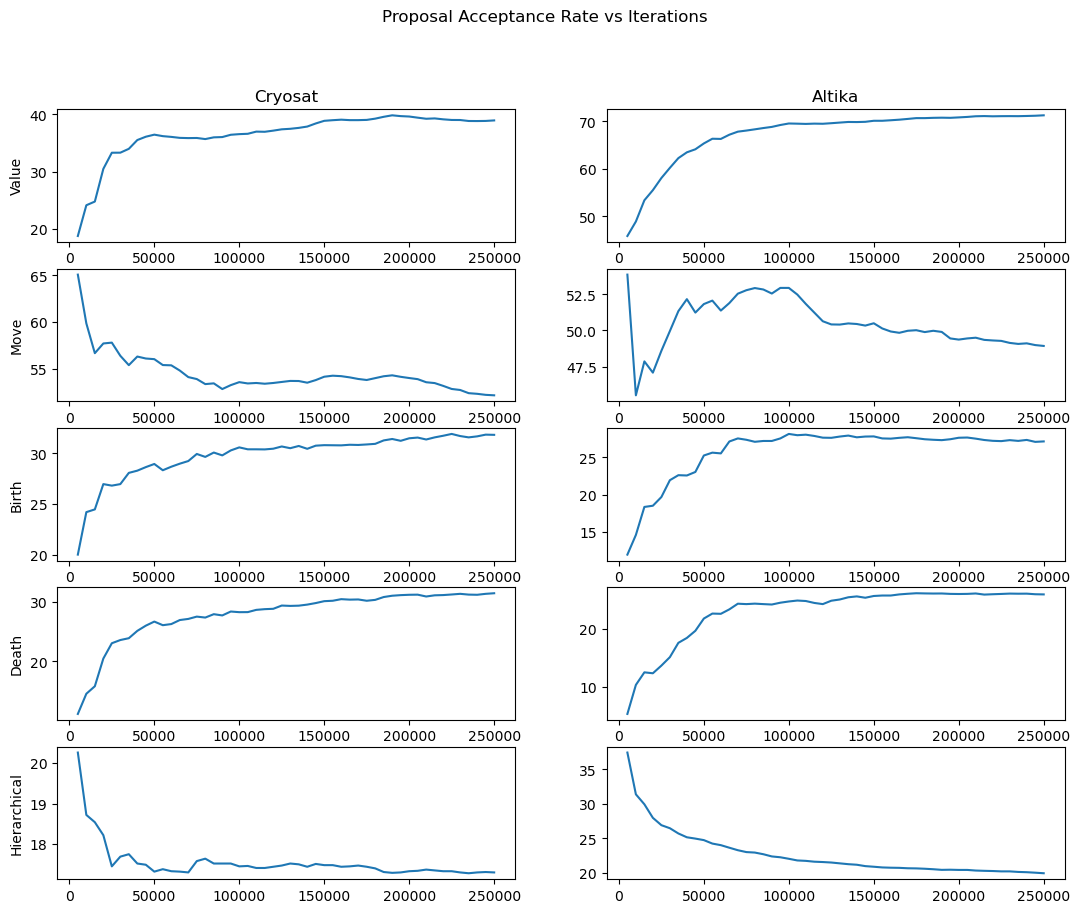

In [191]:
file = 'results/log.txt-000'

iterations = np.arange(5000,250001,5000)

keywords = ["Value", "Move", "Birth", "Death", "Hierarchical"]

rate = {key: {"snow": [], "ice": []} for key in keywords}

with open(file) as f:
    for line in f:
        data = line.split()

        for key in keywords:
            if key in line:
                rate[key]["snow"].append(float(data[4]))
                rate[key]["ice"].append(float(data[9]))
            

plt.figure(figsize=(13,10))
plt.suptitle('Proposal Acceptance Rate vs Iterations')

plt.subplot(5,2,1)
plt.plot(iterations, rate["Value"]["snow"], '-')
plt.ylabel("Value")
plt.title('Cryosat')

plt.subplot(5,2,2)
plt.plot(iterations, rate["Value"]["ice"],'-')
plt.title('Altika')

plt.subplot(5,2,3)
plt.plot(iterations, rate["Move"]['snow'],'-')
plt.ylabel("Move")

plt.subplot(5,2,4)
plt.plot(iterations, rate["Move"]['ice'],'-')

plt.subplot(5,2,5)
plt.plot(iterations, rate["Birth"]['snow'],'-')
plt.ylabel("Birth")
plt.subplot(5,2,6)
plt.plot(iterations, rate["Birth"]['ice'],'-')

plt.subplot(5,2,7)
plt.plot(iterations, rate["Death"]['snow'],'-')
plt.ylabel("Death")
plt.subplot(5,2,8)
plt.plot(iterations, rate["Death"]['ice'],'-')

plt.subplot(5,2,9)
plt.plot(iterations, rate["Hierarchical"]['snow'],'-')
plt.ylabel("Hierarchical")
plt.subplot(5,2,10)
plt.plot(iterations, rate["Hierarchical"]['ice'],'-')

plt.show()